In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
from sklearn.preprocessing import scale
from scipy import stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

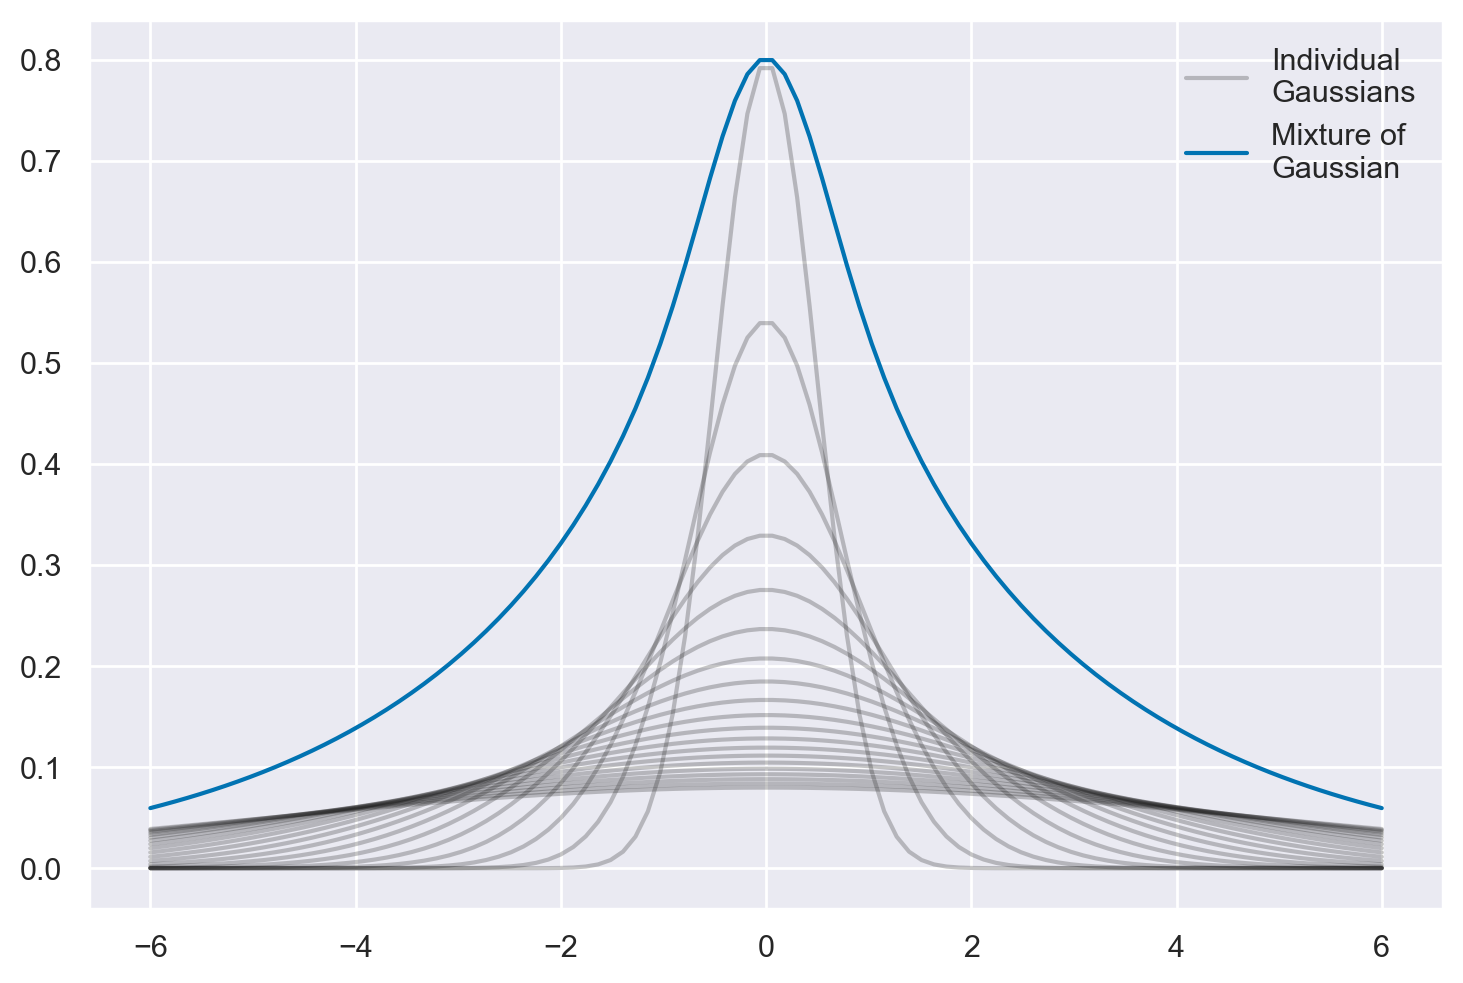

In [3]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Inizializzazione dell'array per i PDF (Probability Density Function)
pdfs = []

# Numero di gaussiane
n_gaussians = 20

# Ciclo per tracciare ogni gaussiana
for variance in np.linspace(.5, 5, n_gaussians):
    label = "Individual\nGaussians" if variance == .5 else None
    pdf = stats.norm(0, variance).pdf(xs)
    pdfs.append(pdf)
    plt.plot(xs, pdf, color='k', label=label, alpha=.25)  # Usa matplotlib.pyplot.plot

# Calcolo della somma dei PDFs
sum_of_pdfs = np.array(pdfs).sum(axis=0)
sum_of_pdfs /= sum_of_pdfs.max()
sum_of_pdfs *= (1 - n_gaussians / 100)

# Tracciare la somma dei PDFs
plt.plot(xs, sum_of_pdfs, color='C0', label='Mixture of\nGaussian')

# Aggiungere la legenda
plt.legend()

# Mostrare il grafico
plt.show()

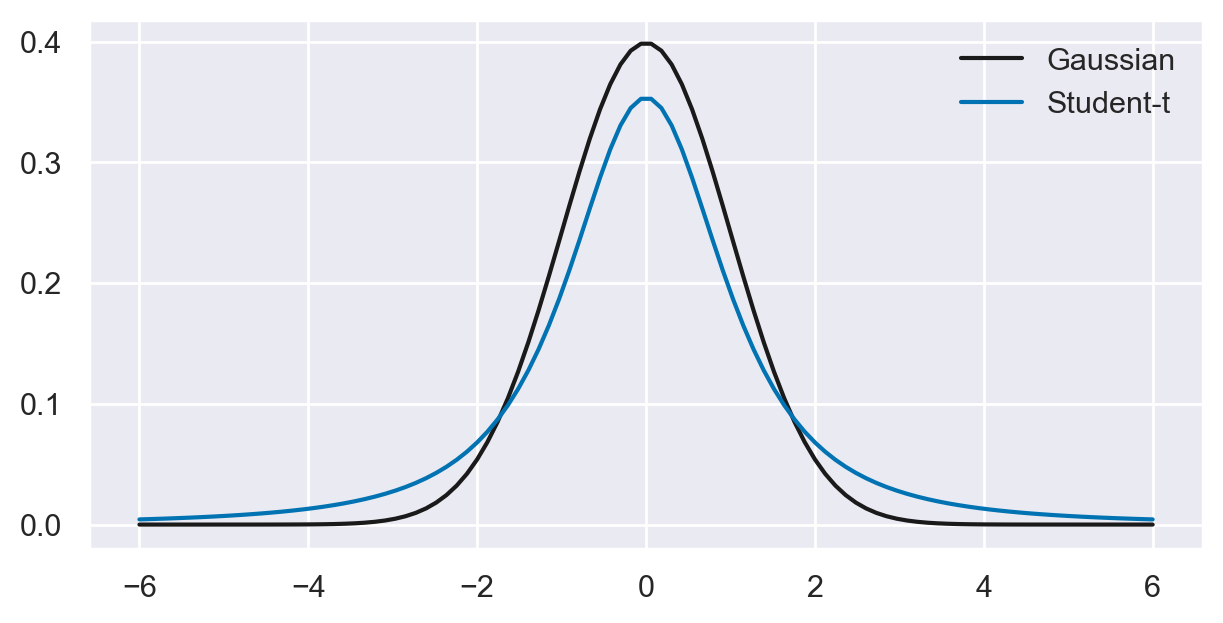

In [4]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Configurazione delle dimensioni del grafico
plt.subplots(figsize=(6, 3))

# Tracciare la distribuzione normale (Gaussiana)
plt.plot(xs, stats.norm.pdf(xs), color='k', label='Gaussian')

# Tracciare la distribuzione Student-t
plt.plot(xs, stats.t(2).pdf(xs), color='C0', label='Student-t')

# Aggiungere la legenda
plt.legend()

# Mostrare il grafico
plt.show()


In [5]:
divorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


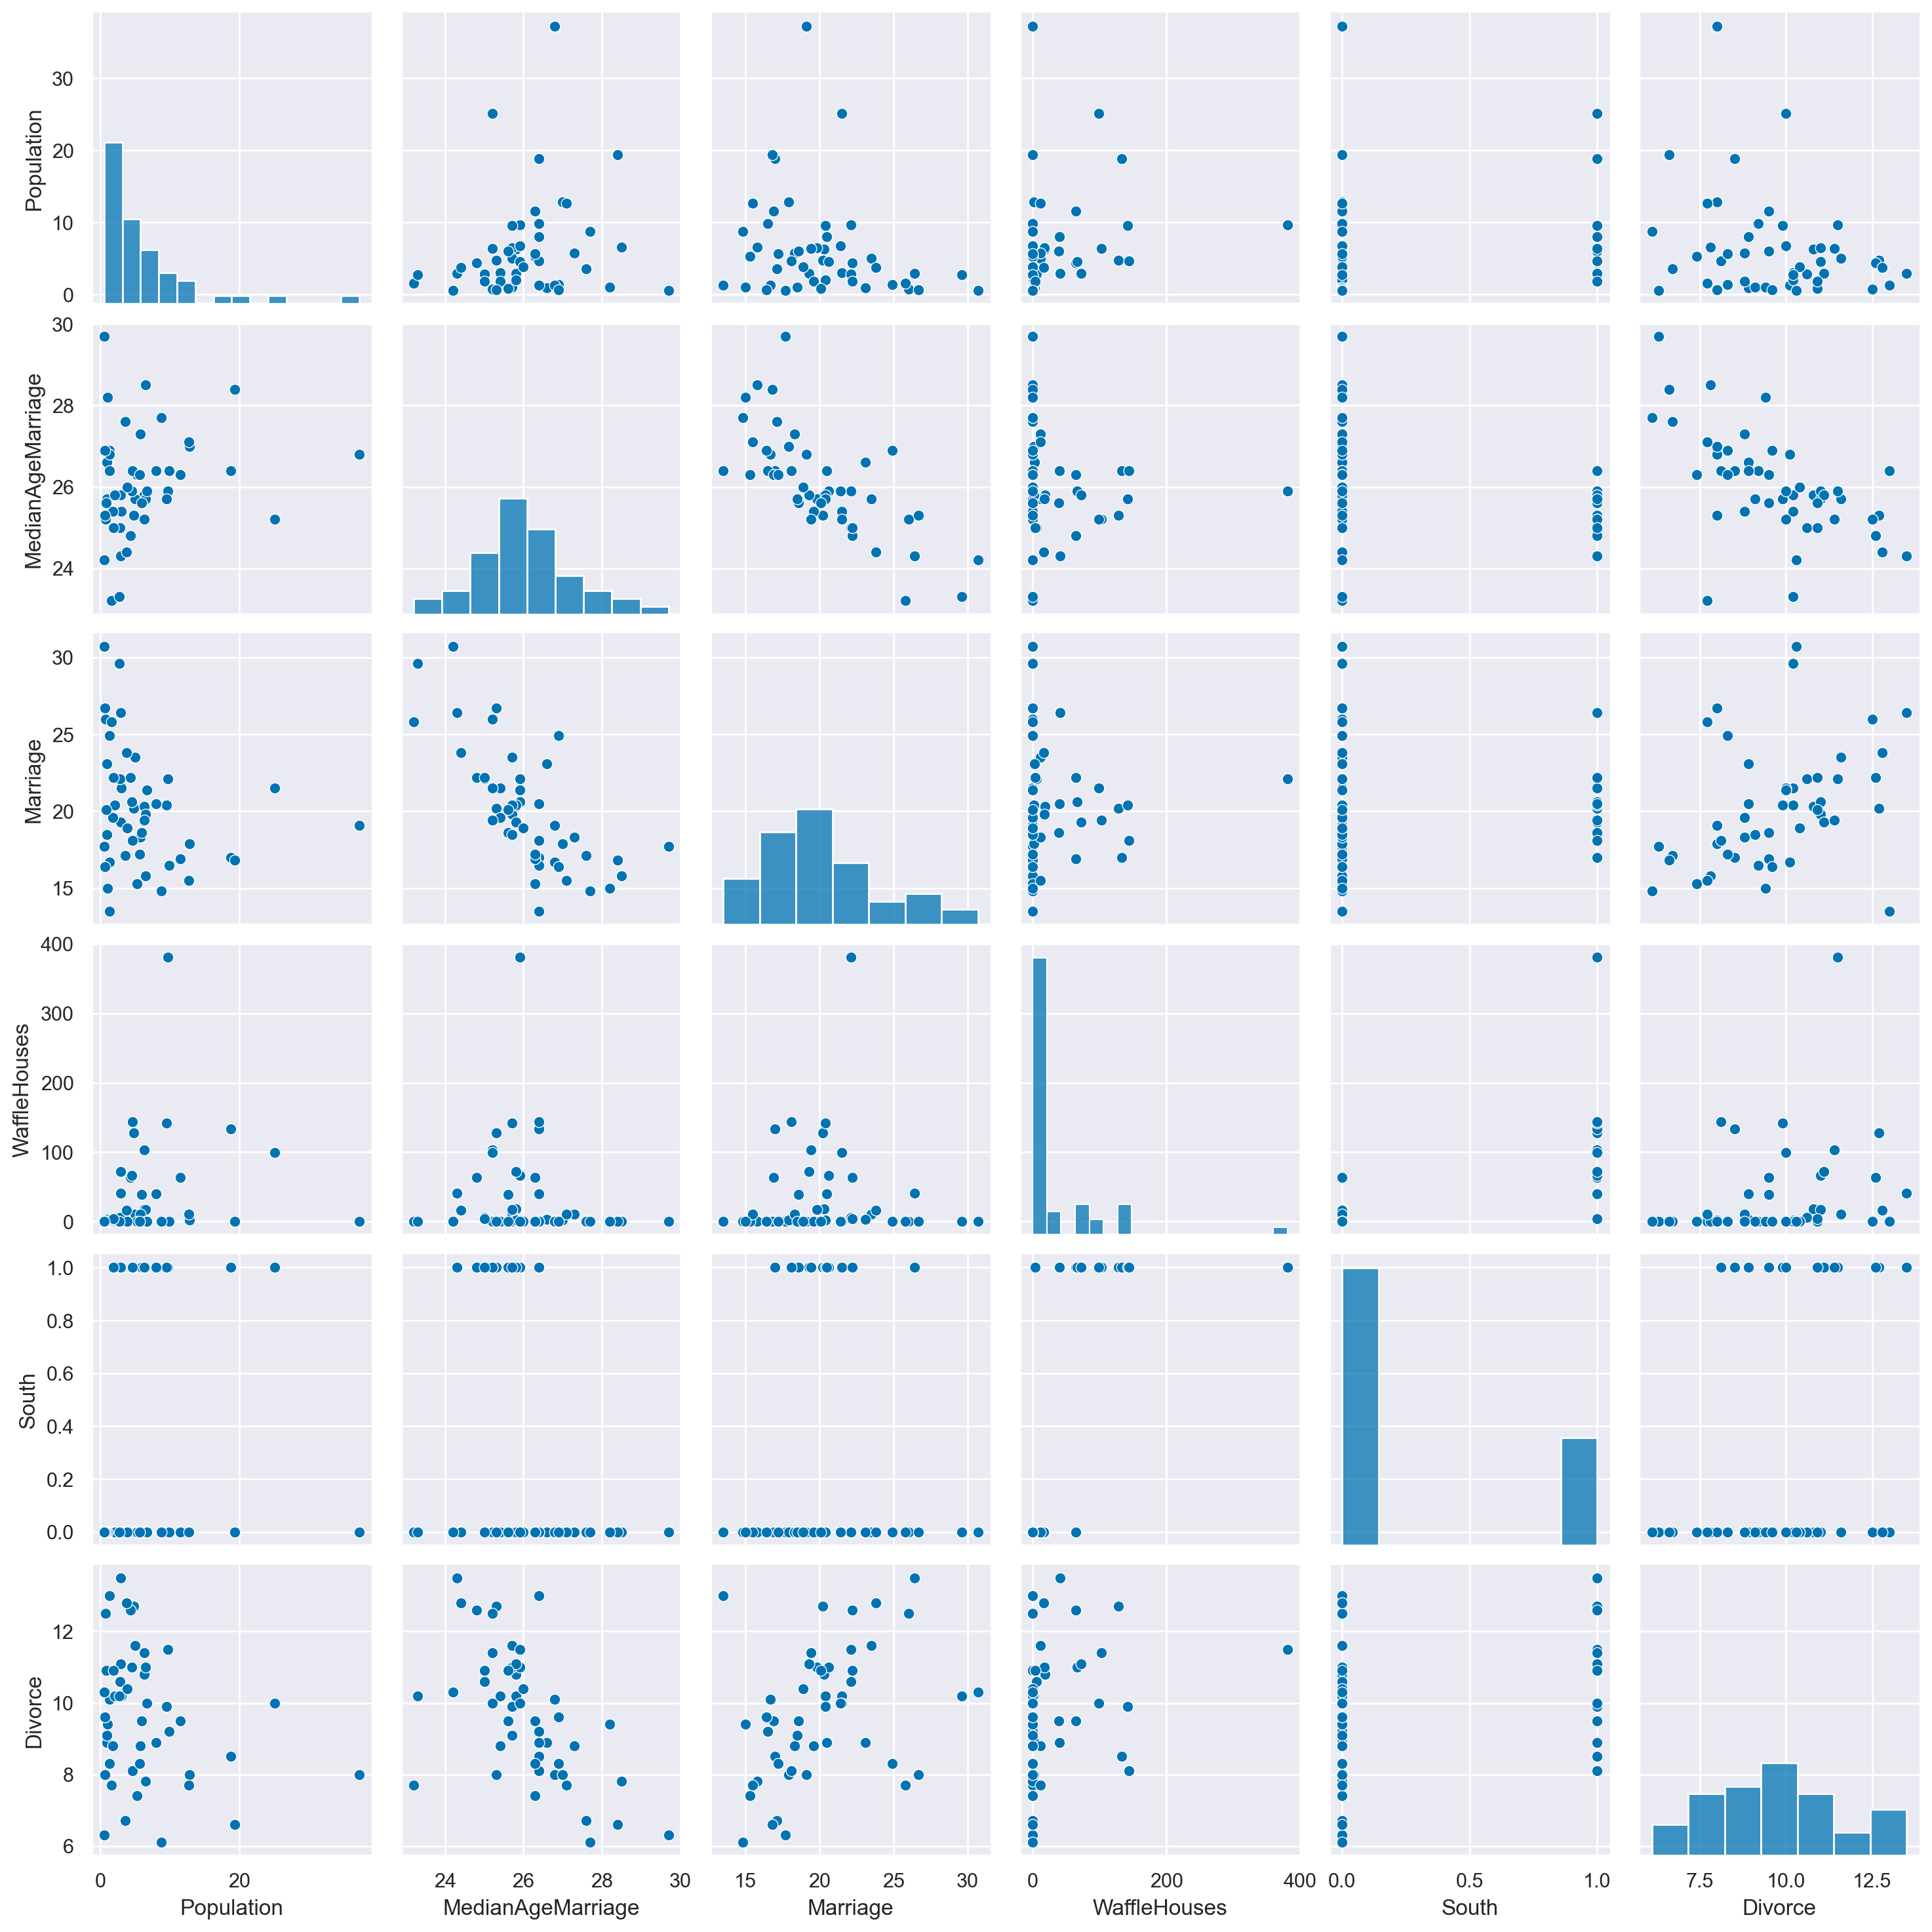

In [6]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(divorce, x_vars=vars, y_vars=vars);

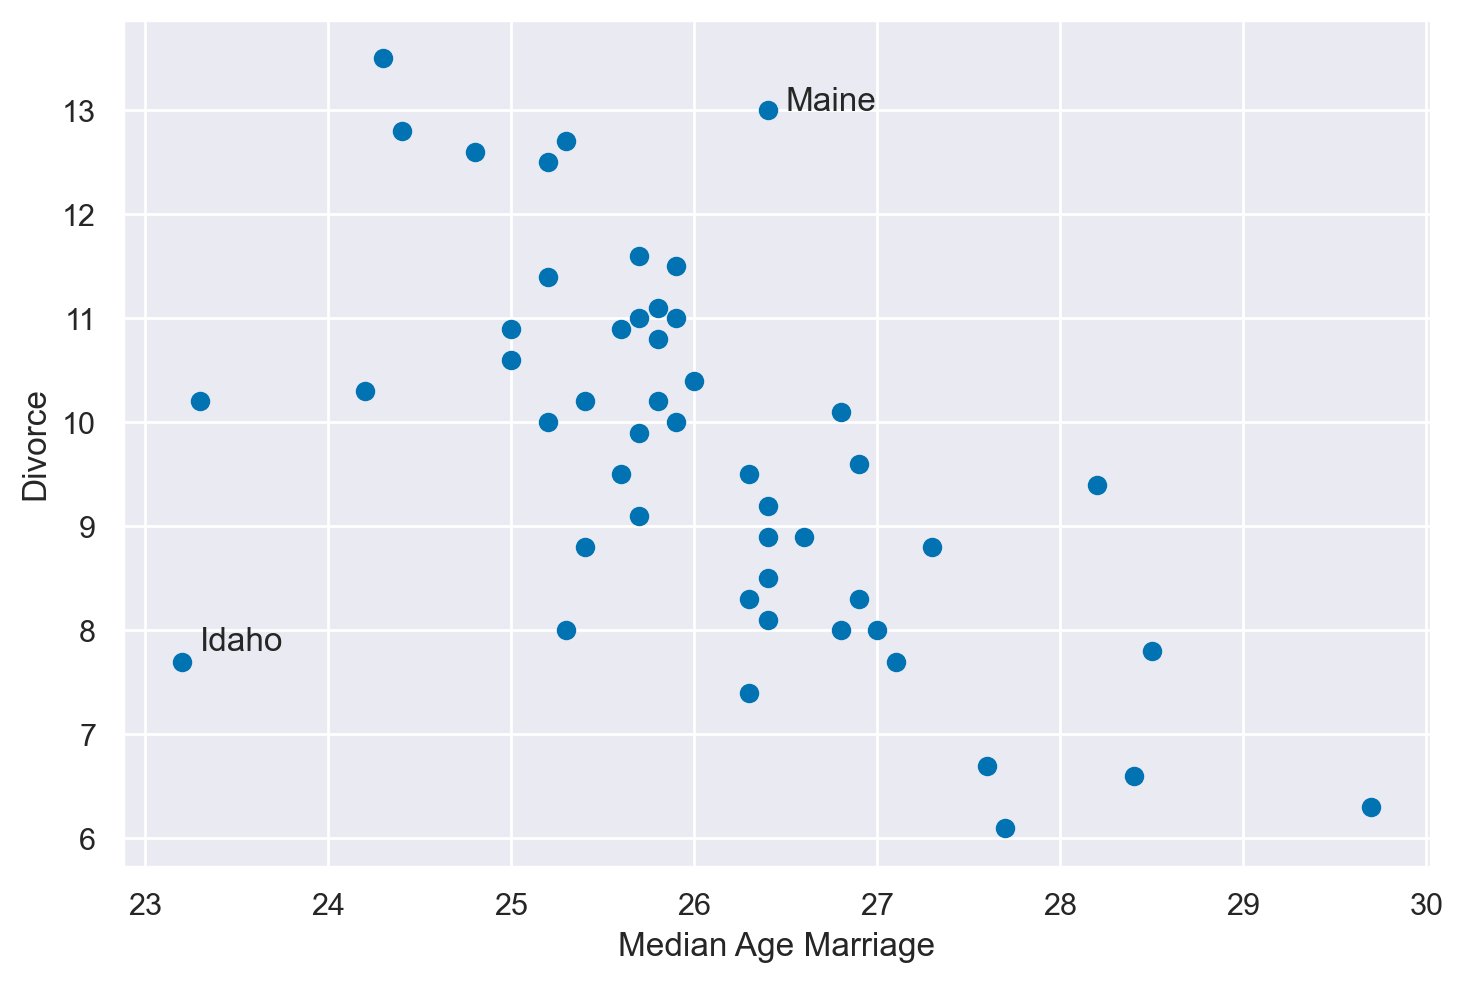

In [7]:
plt.scatter(divorce["MedianAgeMarriage"], divorce["Divorce"])

# Annotare il punto (26.5, 13) con 'Maine'
plt.annotate('Maine', xy=(26.5, 13), xytext=(26.5, 13))
# Annotare il punto (23.3, 7.8) con 'Idaho'
plt.annotate('Idaho', xy=(23.3, 7.8), xytext=(23.3, 7.8))

plt.xlabel("Median Age Marriage")
plt.ylabel("Divorce")
plt.show()

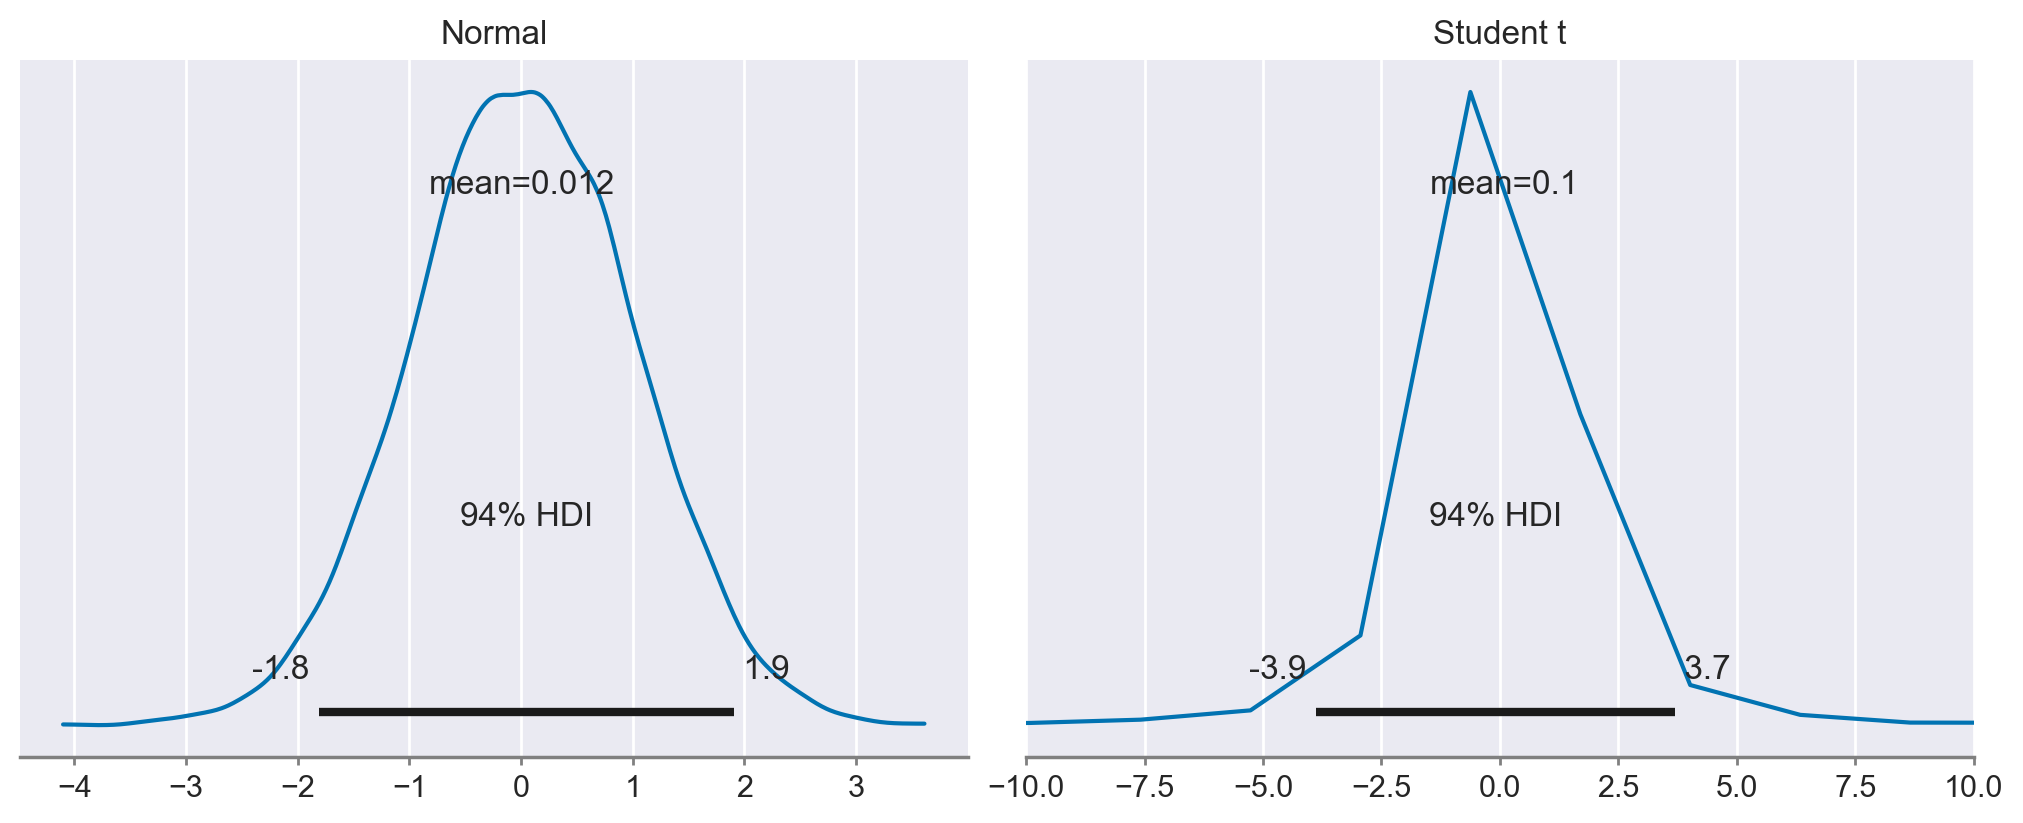

In [8]:
az.plot_posterior(
    {
        "Normal": np.random.normal(size=10000),
        "Student t": np.random.standard_t(df=2, size=10000),
    },
    figsize=(10, 4)
)
plt.xlim(-10, 10);

In [9]:
A = scale(divorce["MedianAgeMarriage"])
D = scale(divorce["Divorce"]) # tasso di divorzio
M = scale(divorce["Marriage"]) # tasso di matrimonio

In [10]:
with pm.Model() as n_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.Normal("D", mu, sigma, observed=D)
    
    n_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:03.333444


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1210.15it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1210.84it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1212.02it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1213.14it/s]


Sampling time = 0:00:02.023115


Transforming variables...


Transformation time = 0:00:00.088267


Computing Log Likelihood...


Log Likelihood time = 0:00:00.142621


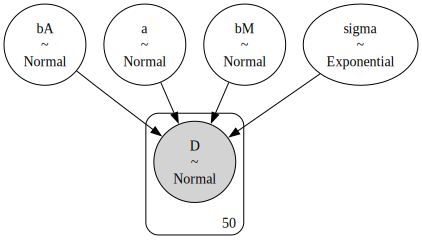

In [11]:
pm.model_to_graphviz(n_model)

In [12]:
with pm.Model() as t_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.StudentT("D", mu=mu, sigma=sigma, nu=2, observed=D)

    t_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.855524


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1381.49it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1382.40it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1383.39it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1384.26it/s]


Sampling time = 0:00:01.546998


Transforming variables...


Transformation time = 0:00:00.044087


Computing Log Likelihood...


Log Likelihood time = 0:00:00.161240


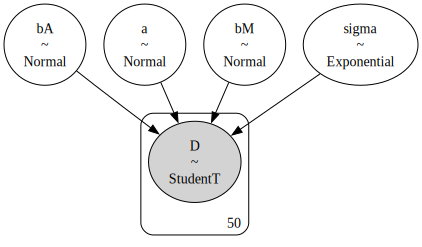

In [13]:
pm.model_to_graphviz(t_model)

In [14]:
az.summary(n_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.605,0.155,-0.905,-0.318,0.003,0.002,2864.0,2516.0,1.0
bM,-0.059,0.155,-0.353,0.232,0.003,0.002,2438.0,2633.0,1.0
a,-0.002,0.112,-0.199,0.215,0.002,0.002,3848.0,2534.0,1.0
sigma,0.835,0.089,0.674,0.999,0.001,0.001,3712.0,3062.0,1.0


In [15]:
az.summary(t_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.698,0.145,-0.962,-0.414,0.002,0.002,3577.0,2982.0,1.0
bM,0.048,0.201,-0.308,0.441,0.003,0.003,3460.0,2422.0,1.0
a,0.029,0.117,-0.199,0.242,0.002,0.002,3514.0,2488.0,1.0
sigma,0.589,0.089,0.429,0.756,0.001,0.001,4060.0,2812.0,1.0


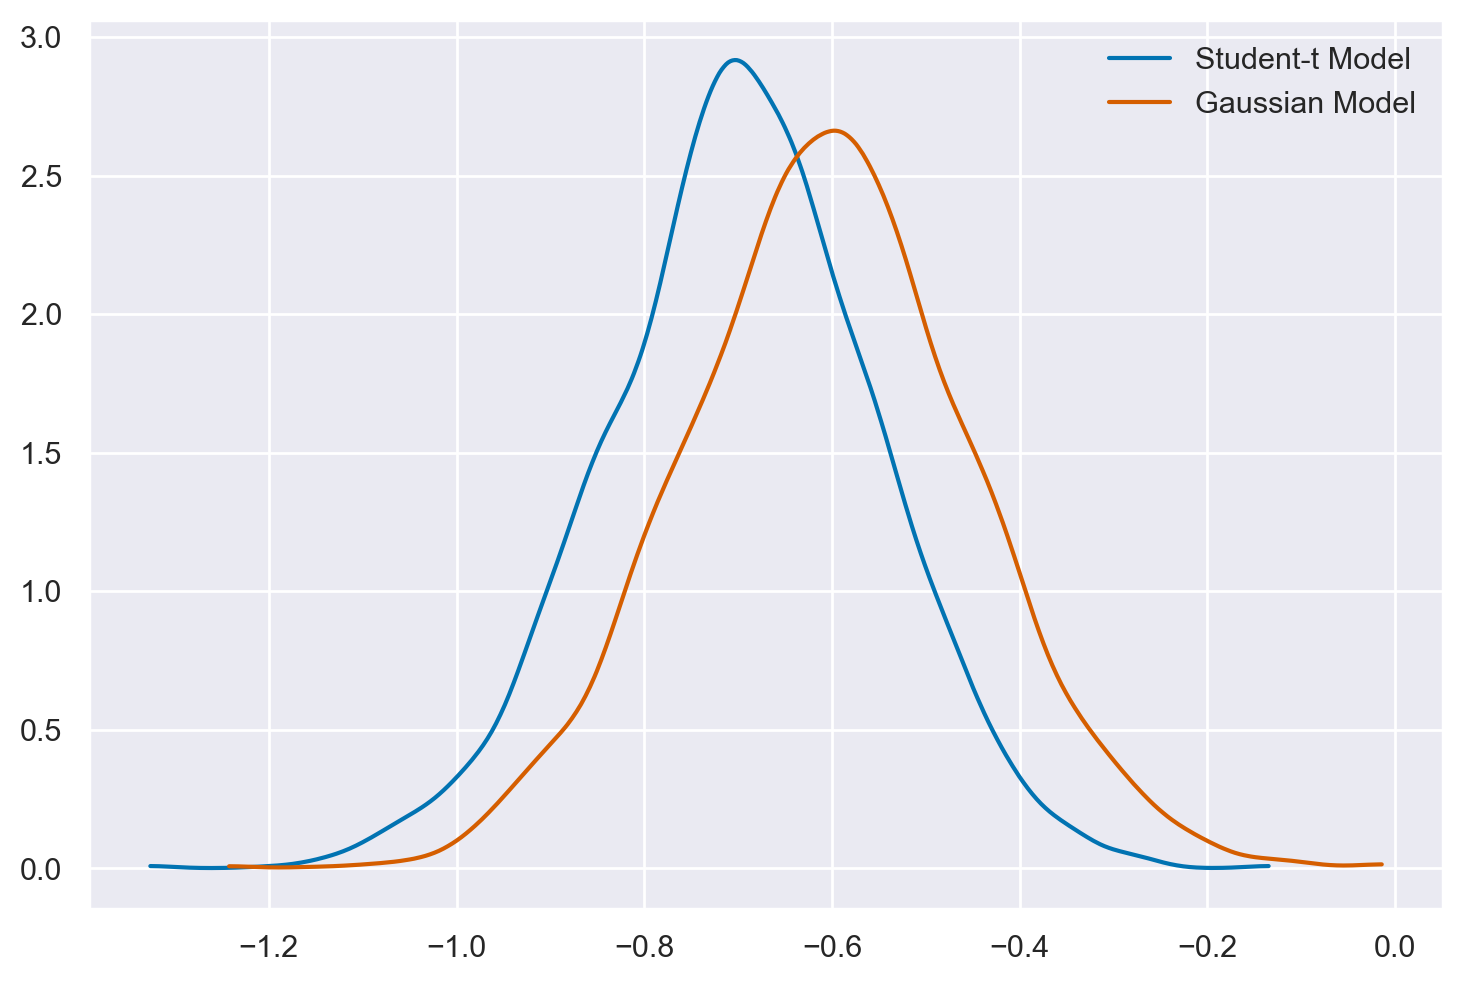

In [16]:
az.plot_dist(t_sample.posterior["bA"], color="C0", label="Student-t Model")
az.plot_dist(n_sample.posterior["bA"], color="C3", label="Gaussian Model");

In [17]:
az.loo(n_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -64.63     6.50
p_loo        5.05        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    2.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
az.loo(t_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -67.08     5.67
p_loo        6.28        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [19]:
def plot_loocv(inference, title=None, outliers_idx=[], divorce=None):
    plt.subplots(figsize=(6,3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    plt.scatter(pareto_k, waic, color='C0', label=None)

    # Assicurati che outliers_idx e divorce siano definiti
    for oi in outliers_idx:
        if divorce is not None and oi in divorce.index:
            plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + .01, waic[oi]), fontsize=14)

    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC")
    plt.title(title)
    plt.show()

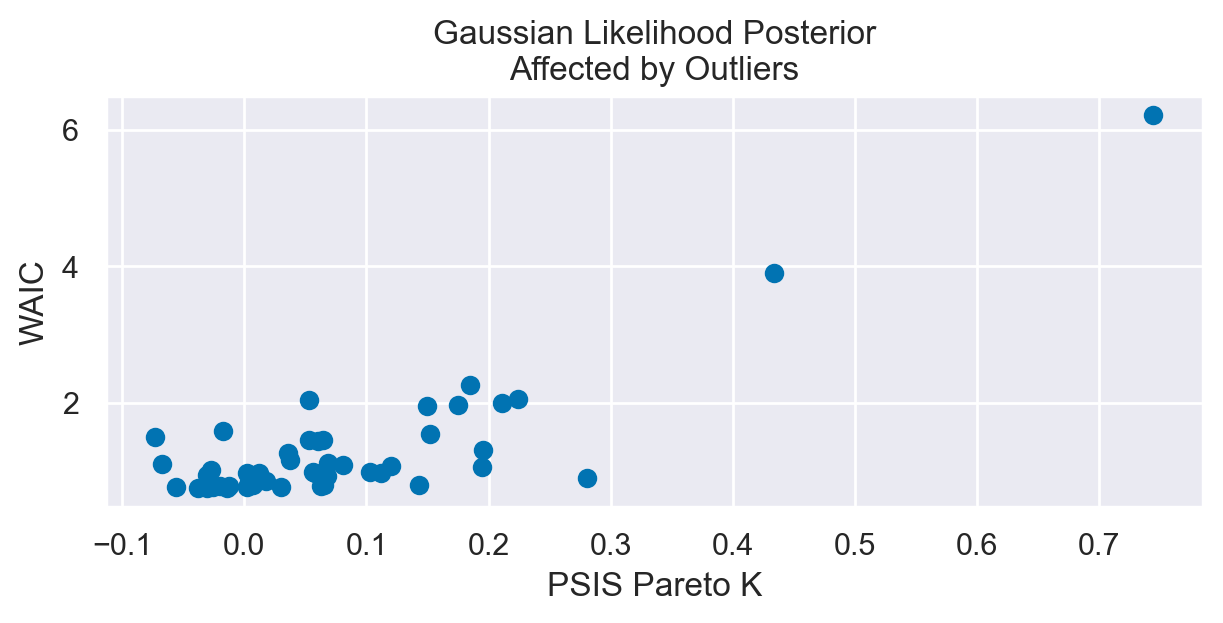

In [20]:
plot_loocv(n_sample, title="Gaussian Likelihood Posterior\nAffected by Outliers")

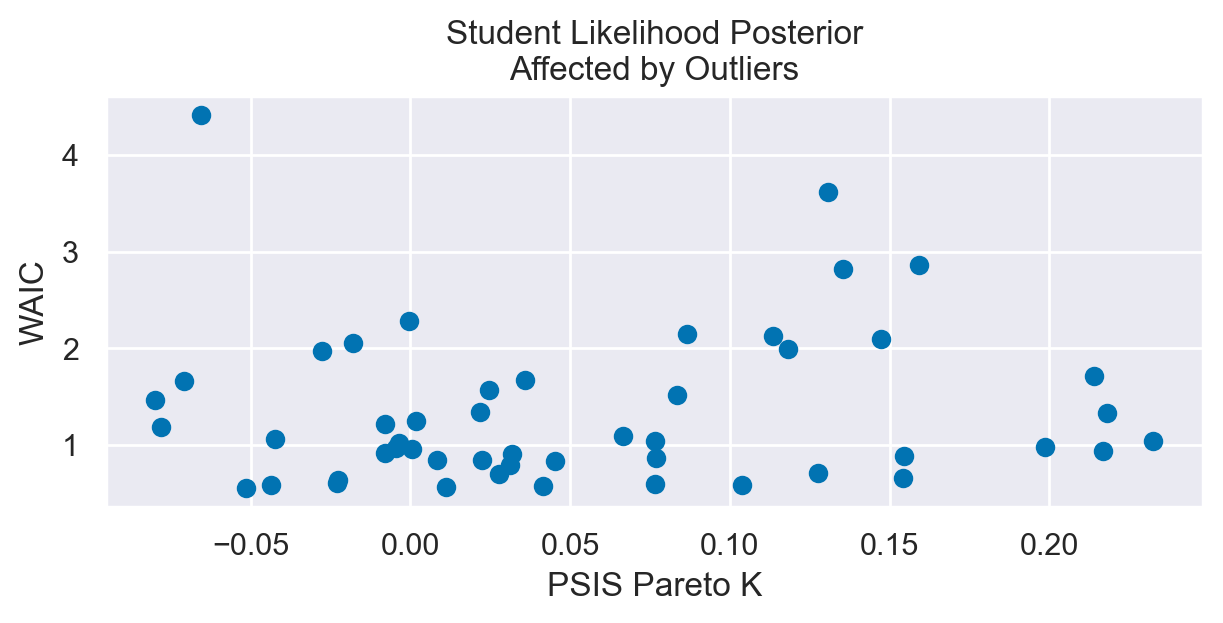

In [21]:
plot_loocv(t_sample, title="Student Likelihood Posterior\nAffected by Outliers")

In [22]:
comparison = az.compare(
    {
        "Gaussian Model": n_sample,
        "Student t Model": t_sample
    }, 
    scale='deviance'
)
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gaussian Model,0,129.250976,5.046424,0.000000,0.812599,13.008751,0.000000,True,deviance
Student t Model,1,134.152641,6.277708,4.901664,0.187401,11.349780,6.065355,False,deviance


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Jan 26 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pytensor: 2.18.4

scipy     : 1.11.4
arviz     : 0.17.0
seaborn   : 0.13.0
pandas    : 2.1.4
numpy     : 1.26.2
pymc      : 5.10.3
matplotlib: 3.8.2

Watermark: 2.4.3

